In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(f'tensorflow version is {tf.__version__}')
print(f'keras version is {keras.__version__}')

tensorflow version is 2.12.0
keras version is 2.12.0


In [2]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Prepare the dataset


In [4]:
!unzip -q /content/bikes_and_planes.zip

## Feature extraction using the pre-trained convnet


In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
base_dir = '/content/bikes_and_planes'
# If using JupyterLab, use the following base directory:
# base_dir = 'dogs_vs_cats_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


In [11]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 100

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [13]:
train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 300)
test_features, test_labels = extract_features(test_dir, 300)

Found 1000 images belonging to 2 classes.
4/4 [==============================] - 0s 56ms/step
Found 300 images belonging to 2 classes.
4/4 [==============================] - 0s 57ms/step
Found 300 images belonging to 2 classes.
4/4 [==============================] - 0s 57ms/step


In [14]:
train_features.shape

(1000, 4, 4, 512)

The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [18]:
train_features = np.reshape(train_features, (1000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (300, 4 * 4 * 512))
test_features = np.reshape(test_features, (300, 4 * 4 * 512))

## Classification
At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [19]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

#model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
#              loss='binary_crossentropy',
#              metrics=['acc'])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/20
50/50 [==============================] - 2s 8ms/step - loss: 0.2672 - acc: 0.9410 - val_loss: 5.9624e-04 - val_acc: 1.0000
Epoch 2/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0135 - acc: 0.9950 - val_loss: 4.0140e-04 - val_acc: 1.0000
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 5.7592e-05 - val_acc: 1.0000
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0023 - acc: 0.9990 - val_loss: 2.2993e-05 - val_acc: 1.0000
Epoch 5/20
50/50 [==============================] - 0s 5ms/step - loss: 2.4240e-04 - acc: 1.0000 - val_loss: 2.3787e-05 - val_acc: 1.0000
Epoch 6/20
50/50 [==============================] - 0s 4ms/step - loss: 8.4600e-05 - acc: 1.0000 - val_loss: 2.2653e-06 - val_acc: 1.0000
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 1.2265e-04 - acc: 1.0000 - val_loss: 7.8543e-06 - val_acc: 1.0000
Epoch 8/20
50/50 [==============================] 

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

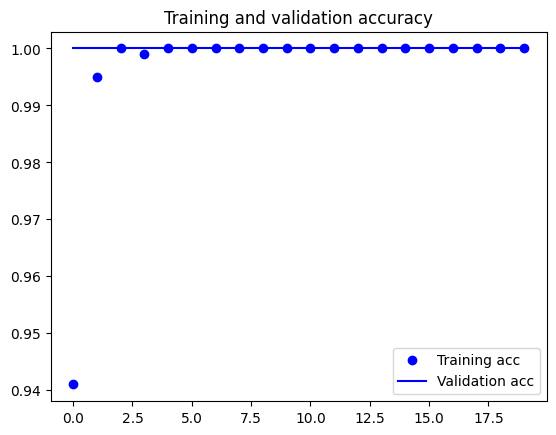

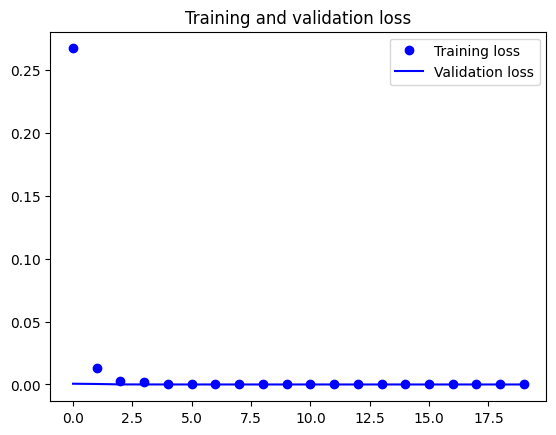

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


We reach a validation accuracy of about 90%, which is already impressive. 

However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. This is because our dataset is very small in size (for an image classification task). Training over a larger dataset will help alleviating overfitting.

### Performance of the trained classifier

Let's see how the trained classifier performs on the hold-out test dataset:

In [21]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('test acc:', test_acc)

10/10 [==============================] - 0s 4ms/step - loss: 0.0120 - acc: 0.9967
test acc: 0.996666669845581


## Prediction

In [25]:
img_path = '/content/bikes_and_planes/test/bikes/145_0799.jpg'
# img_path = 'dogs_vs_cats_small/test/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor
#obsolete: from keras.preprocessing import image
from keras import utils

#obsolete: img = image.load_img(img_path, target_size=(150, 150))
img = utils.load_img(img_path, target_size=(150, 150))

#obsolete: img_tensor = image.img_to_array(img)
img_tensor = utils.img_to_array(img)

# Change the array shape from (150, 150, 3) to (1, 150, 150, 3), so that it matches the 
# input shape of VGG16 where the first axis indicates the number of pictures in the batch. 
img_tensor = np.expand_dims(img_tensor, axis=0)

# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


In [26]:
features_extracted = conv_base.predict(img_tensor)
features_flattened = np.reshape(features_extracted, (1, 4 * 4 * 512))
predicted = model.predict(features_flattened)
predicted

1/1 [==============================] - 0s 51ms/step


array([[0.9729618]], dtype=float32)

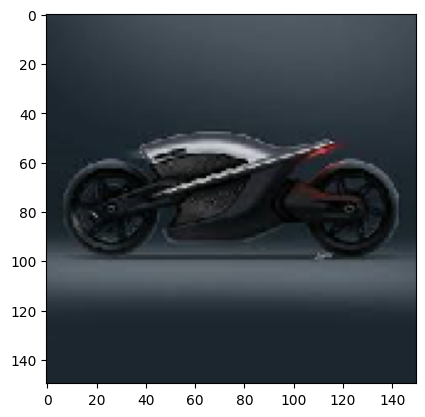

In [27]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()